# **Evaluación del modelo siames**
***

El objetivo de este experimento es evaluar la robustez y precisión de la red siamesa al enfrentar imágenes desafiantes.

<a id="1"></a>
## 1. Carga de datos

Importacion de librerias

In [425]:
#instalacion
!pip install memory-profiler
!pip install glob2
!pip install Pillow
%load_ext memory_profiler
!pip install tables scipy matplotlib
#importacion librerias
import numpy as np
import seaborn as sns
from google.colab import drive
import os
import glob
import cv2
import tensorflow as tf
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, Model
from keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import tables
import matplotlib.image as mpimg
from __future__ import annotations
from scipy.cluster.hierarchy import linkage, dendrogram
from dataclasses import dataclass
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
from functools import reduce
from datetime import datetime
from keras.preprocessing import image
from typing import Union

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [426]:
#conexion drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carga de la red neuronal preentrenada

In [427]:
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

<a id="2"></a>
## 2. Definición de  funciones

Funciones requeridas por la red neuornal siamesa.

In [428]:
def get_celebrities(n_celebrities:int, refactor_class=False):
    df1, df2 = get_max_aparicions(get_identities(), n_celebrities)
    #df.reset_index(inplace=True, drop=True)
    if refactor_class:
        df1 = refactor_identity(df1, 'Identity')
    return df1, df2


def get_max_aparicions(df:pd.DataFrame, n_celebrities:int):
    aparicions_df = df["Identity"].value_counts()
    aparicions_df = aparicions_df.reset_index()
    aparicions_df = aparicions_df.rename(columns={'Identity':'aparicions', 'index':'Identity'})
    aparicions_df = aparicions_df.iloc[:n_celebrities]
    return df[df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True), df[~df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True)

def get_identities():
    identity_df = pd.read_csv("/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Anno/identity_CelebA.txt", sep=' ', header=None)
    identity_df = identity_df.rename(columns={0:"Image_name", 1:"Identity"})
    return identity_df

def refactor_identity(df, traget_col):
    d = get_dic_index(df, traget_col)
    df["Class"] = df.apply(lambda row: d[row[traget_col]], axis=1)
    return df

def get_dic_index(df, traget_col):
    df = df[traget_col].value_counts()
    dic_index = df.to_dict()
    i = 0
    for c in dic_index:
        dic_index[c] = i
        i += 1
    return dic_index
def get_tvt(df:pd.DataFrame, target_name:str, train_size:int):
    total_classes = df[target_name].nunique()
    n_df_col = df.shape[0]
    df = shuffle(df)
    train_df = df.iloc[:int(n_df_col*train_size)]
    val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
    test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
    while True:
        if train_df[target_name].nunique() == total_classes and val_df[target_name].nunique() == total_classes and test_df[target_name].nunique() == total_classes:
            return train_df, val_df, test_df

        df = shuffle(df)
        train_df = df.iloc[:int(n_df_col*train_size)]
        val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
        test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
class DataGenerator(Sequence):
  def __init__(self, df, batch_size=32, img_size=(200,200), img_dir= './', shuffle=True):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_dir = img_dir
    self.df = df
    self.indices = self.df.index.tolist()
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // self.batch_size

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]

    X1, X2, y = self.__get_data(batch)
    return [X1, X2], y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    X2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = np.zeros((self.batch_size,), dtype="float32")
    for i, idx in enumerate(batch):
      X1[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image1'], target_size=self.img_size))
      X2[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image2'], target_size=self.img_size))
      y[i] = self.df.loc[idx,'Sim']
    return X1, X2, y


class EuclideanDLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, x, y):
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [429]:
 def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

In [430]:
siamese = load_model('/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/Weights/2023-10-07 10h 33m_test_8.best',
                     custom_objects={'KerasLayer': hub.KerasLayer,
                                     'EuclideanDLayer': EuclideanDLayer,
                                     'contrastive_loss': contrastive_loss})

<a id="3"></a>
## 3. Obtencion  similitud

En este apartado se obtendrá la similitud entre las imagenes requeridas.

In [431]:
ruta_imagenes = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/prueba/'

In [432]:
target_size = (178, 218)

In [433]:
def calcular_similitud_siamesa(siamese_model, ruta_imagenes, nombre_imagen1, nombre_imagen2):
    ruta_imagen1 = os.path.join(ruta_imagenes, nombre_imagen1)
    ruta_imagen2 = os.path.join(ruta_imagenes, nombre_imagen2)
    img1 = image.load_img(ruta_imagen1, target_size=(178, 218))
    img1 = image.img_to_array(img1)
    img1 = np.expand_dims(img1, axis=0)
    img2 = image.load_img(ruta_imagen2, target_size=(178, 218))
    img2 = image.img_to_array(img2)
    img2 = np.expand_dims(img2, axis=0)
    embedding1 = siamese.predict([img1, img2])
    similitud = 1.0 - embedding1[0][0]
    df_similitud = pd.DataFrame({'Imagen1': [nombre_imagen1], 'Imagen2': [nombre_imagen2], 'Similitud': [similitud]})

    return df_similitud

def visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Similitud: {similitud}', size=16)

    img_referencia = mpimg.imread(os.path.join(ruta_imagenes, nombre_imagen1))
    ax1.imshow(img_referencia)
    ax1.set_title('Imagen1')
    ax1.axis('off')

    img_asociada1 = mpimg.imread(os.path.join(ruta_imagenes, nombre_imagen2))
    ax2.imshow(img_asociada1)
    ax2.set_title(f'Imagen2')
    ax2.axis('off')

# **PRUEBA 1**

In [340]:
nombre_imagen1 ='brad.jpg'
nombre_imagen2 = 'hija.jpg'

In [343]:
df_resultado = calcular_similitud_siamesa(ruta_modelo, ruta_imagenes, nombre_imagen1, nombre_imagen2)

1/1 [==============================] - 1s 1s/step


In [344]:
df_resultado

,Imagen1,Imagen2,Similitud
0,brad.jpg,hija.jpg,0.858402


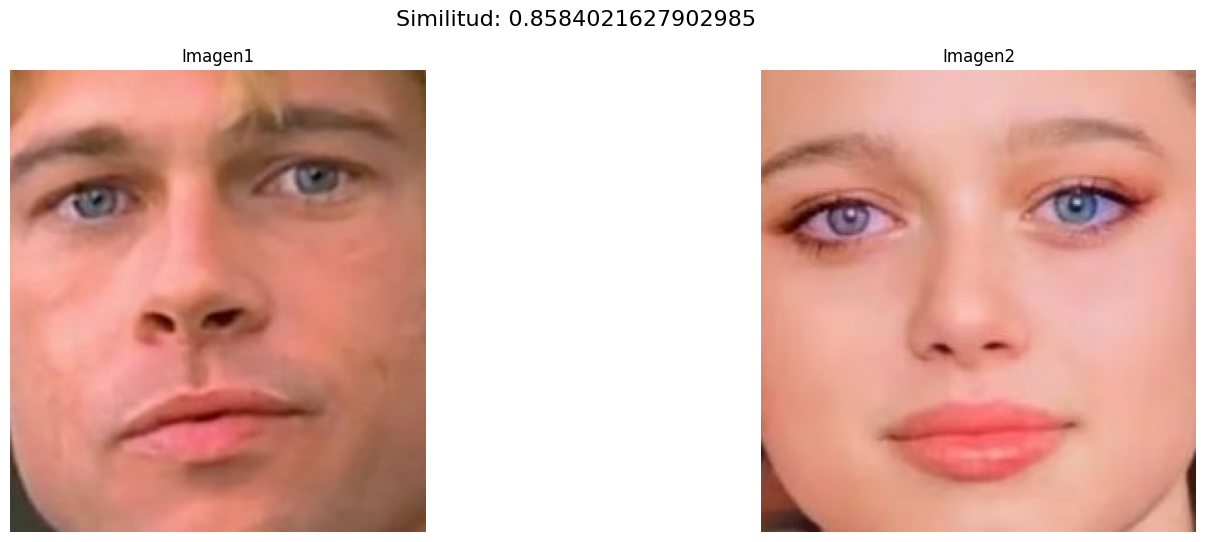

In [345]:
for index, row in df_resultado.iterrows():
    nombre_imagen1 = row['Imagen1']
    nombre_imagen2 = row['Imagen2']
    similitud = row['Similitud']
    visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud)

# **PRUEBA 2**

In [421]:
nombre_imagen1 ='americano.jpg'
nombre_imagen2 = 'americano2.jpg'

In [422]:
df_resultado = calcular_similitud_siamesa(ruta_modelo, ruta_imagenes, nombre_imagen1, nombre_imagen2)

1/1 [==============================] - 0s 251ms/step


In [423]:
df_resultado

,Imagen1,Imagen2,Similitud
0,americano.jpg,americano2.jpg,0.602941


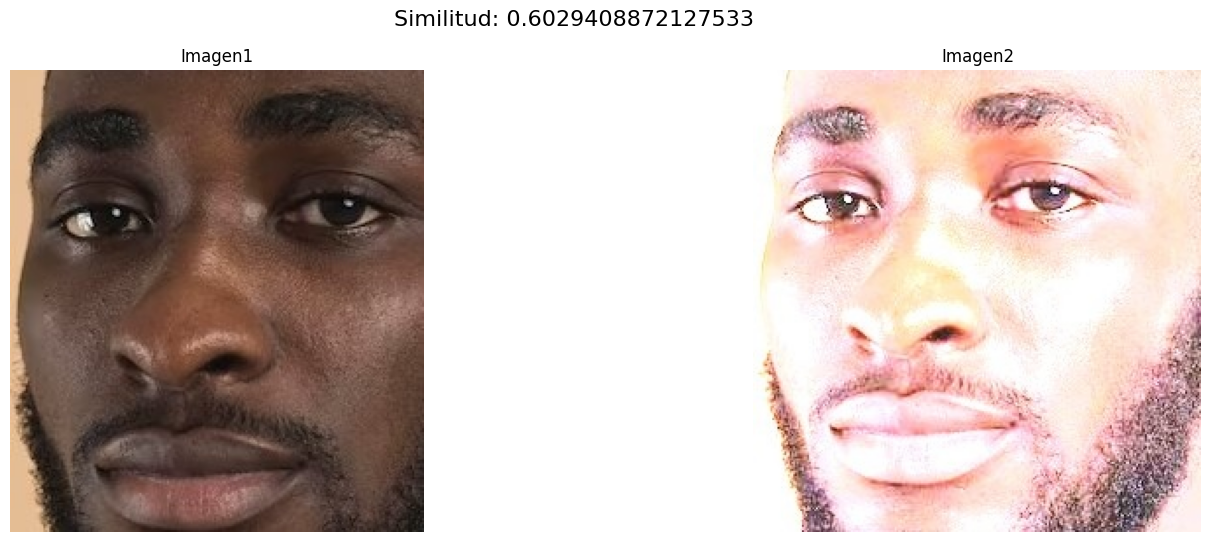

In [424]:
for index, row in df_resultado.iterrows():
    nombre_imagen1 = row['Imagen1']
    nombre_imagen2 = row['Imagen2']
    similitud = row['Similitud']
    visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud)

# **PRUEBA 3**

In [354]:
nombre_imagen1 ='yen_1.jpg'
nombre_imagen2 = 'yen_2.jpg'

In [355]:
df_resultado = calcular_similitud_siamesa(ruta_modelo, ruta_imagenes, nombre_imagen1, nombre_imagen2)

1/1 [==============================] - 0s 240ms/step


In [356]:
df_resultado

,Imagen1,Imagen2,Similitud
0,yen_1.jpg,yen_2.jpg,0.973839


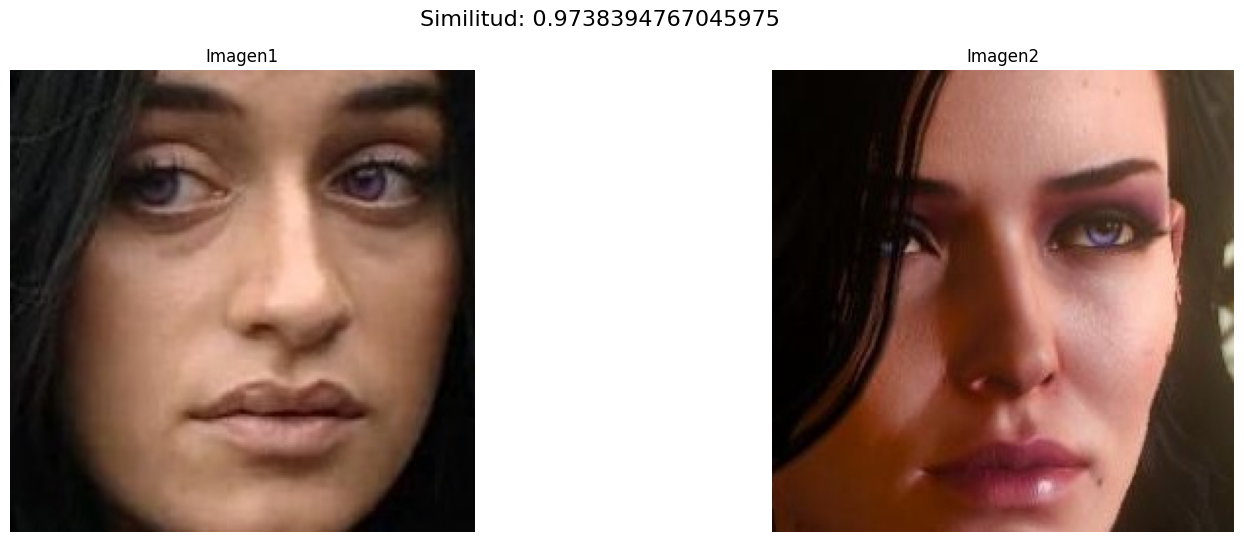

In [357]:
for index, row in df_resultado.iterrows():
    nombre_imagen1 = row['Imagen1']
    nombre_imagen2 = row['Imagen2']
    similitud = row['Similitud']
    visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud)

# **PRUEBA 4**

In [368]:
nombre_imagen1 ='geralt_2.jpg'
nombre_imagen2 = 'geralt_1.jpg'

In [369]:
df_resultado = calcular_similitud_siamesa(ruta_modelo, ruta_imagenes, nombre_imagen1, nombre_imagen2)

1/1 [==============================] - 0s 244ms/step


In [370]:
df_resultado

,Imagen1,Imagen2,Similitud
0,geralt_2.jpg,geralt_1.jpg,0.909673


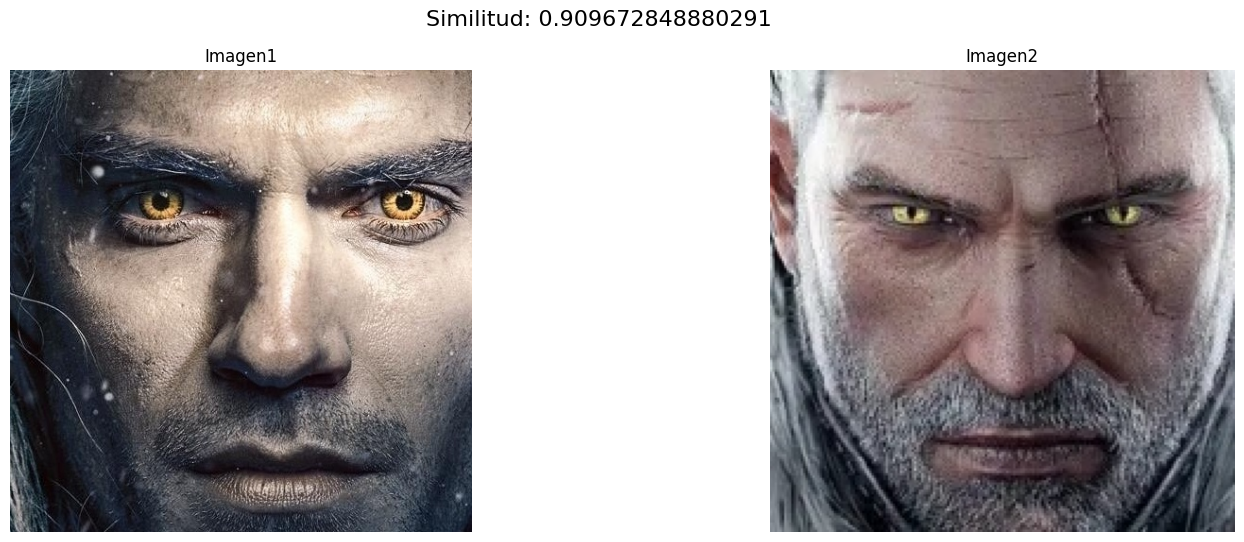

In [372]:
for index, row in df_resultado.iterrows():
    nombre_imagen1 = row['Imagen1']
    nombre_imagen2 = row['Imagen2']
    similitud = row['Similitud']
    visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud)

# **PRUEBA 5**

In [373]:
nombre_imagen1 ='gemelo_1.jpg'
nombre_imagen2 = 'gemelo_2.jpg'

In [374]:
df_resultado = calcular_similitud_siamesa(ruta_modelo, ruta_imagenes, nombre_imagen1, nombre_imagen2)

1/1 [==============================] - 0s 425ms/step


In [375]:
df_resultado

,Imagen1,Imagen2,Similitud
0,gemelo_1.jpg,gemelo_2.jpg,0.930402


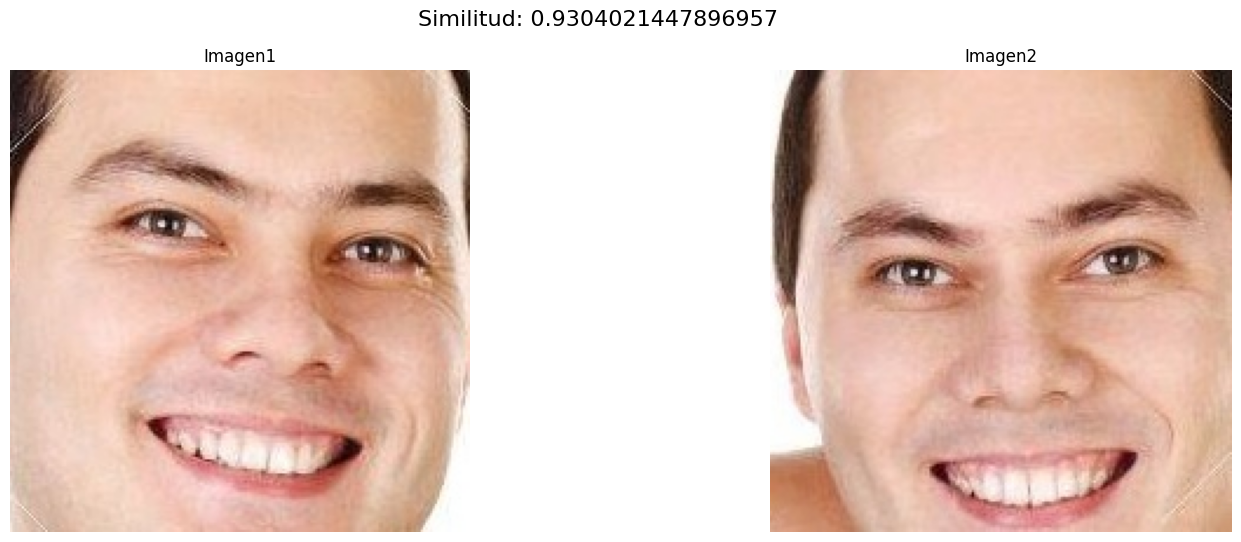

In [376]:
for index, row in df_resultado.iterrows():
    nombre_imagen1 = row['Imagen1']
    nombre_imagen2 = row['Imagen2']
    similitud = row['Similitud']
    visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud)

# **PRUEBA 6**

Modificación de funciones ya que la imagen tiene que estar rotada.

In [362]:
def load_and_fix_orientation(image_path):
    img = Image.open(image_path)
    if hasattr(img, '_getexif'):
        orientation = 0x0112
        exif = img._getexif()
        if exif is not None and orientation in exif:
            orientation = exif[orientation]
            rotations = {
                3: Image.ROTATE_180,
                6: Image.ROTATE_270,
                8: Image.ROTATE_90
            }
            if orientation in rotations:
                img = img.transpose(rotations[orientation])
    return img

def calcular_similitud_siamesa(siamese_model, ruta_imagenes, nombre_imagen1, nombre_imagen2):
    ruta_imagen1 = os.path.join(ruta_imagenes, nombre_imagen1)
    ruta_imagen2 = os.path.join(ruta_imagenes, nombre_imagen2)

    img1 = image.load_img(ruta_imagen1, target_size=(178, 218))
    img1 = image.img_to_array(img1)
    img1 = np.expand_dims(img1, axis=0)

    img2 = load_and_fix_orientation(ruta_imagen2)  # Cargar y corregir la orientación de la imagen 2
    img2 = image.img_to_array(img2)
    img2 = np.expand_dims(img2, axis=0)

    embedding1 = siamese.predict([img1, img2])
    similitud = 1.0 - embedding1[0][0]

    df_similitud = pd.DataFrame({'Imagen1': [nombre_imagen1], 'Imagen2': [nombre_imagen2], 'Similitud': [similitud]})

    return df_similitud

def visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Similitud: {similitud}', size=16)

    img_referencia = load_and_fix_orientation(os.path.join(ruta_imagenes, nombre_imagen1))
    ax1.imshow(img_referencia)
    ax1.set_title('Imagen1')
    ax1.axis('off')

    img_asociada1 = load_and_fix_orientation(os.path.join(ruta_imagenes, nombre_imagen2))
    ax2.imshow(img_asociada1)
    ax2.set_title('Imagen2')
    ax2.axis('off')

    plt.show()

In [363]:
nombre_imagen1 ='116278.jpg'
nombre_imagen2= '116278_2.jpg'

In [364]:
df_resultado = calcular_similitud_siamesa(ruta_modelo, ruta_imagenes, nombre_imagen1, nombre_imagen2)

1/1 [==============================] - 3s 3s/step


In [365]:
df_resultado

,Imagen1,Imagen2,Similitud
0,116278.jpg,116278_2.jpg,0.0


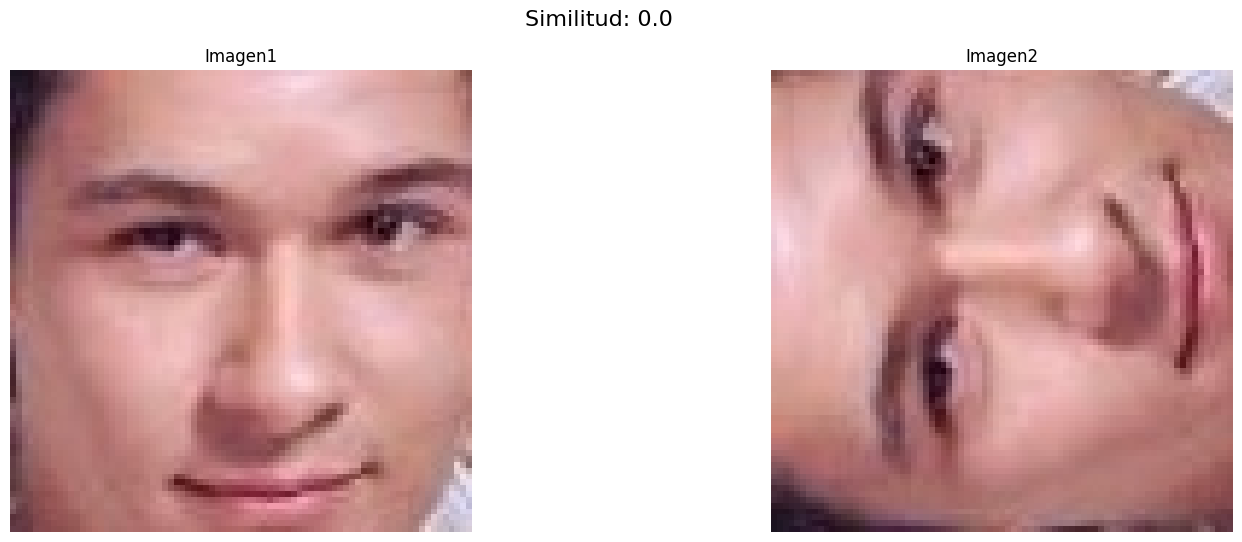

In [366]:
for index, row in df_resultado.iterrows():
    nombre_imagen1 = row['Imagen1']
    nombre_imagen2 = row['Imagen2']
    similitud = row['Similitud']
    visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud)

# **PRUEBA 7**

In [434]:
nombre_imagen1 ='mich.jpg'
nombre_imagen2 = 'bebe.jpg'

In [435]:
df_resultado = calcular_similitud_siamesa(ruta_modelo, ruta_imagenes, nombre_imagen1, nombre_imagen2)

1/1 [==============================] - 1s 1s/step


In [436]:
df_resultado

,Imagen1,Imagen2,Similitud
0,mich.jpg,bebe.jpg,0.8648


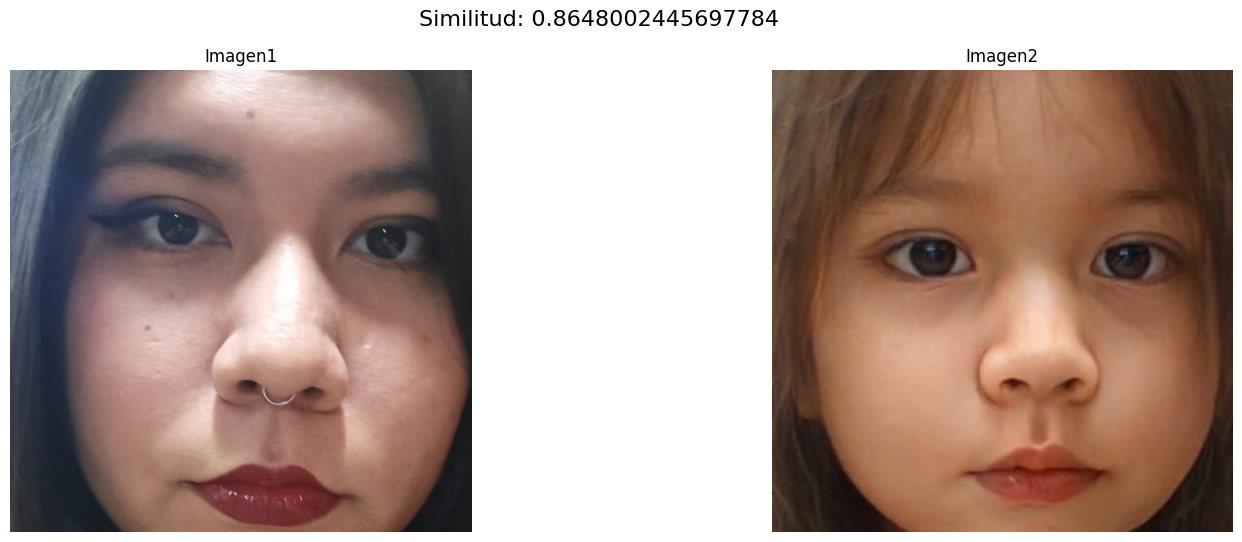

In [437]:
for index, row in df_resultado.iterrows():
    nombre_imagen1 = row['Imagen1']
    nombre_imagen2 = row['Imagen2']
    similitud = row['Similitud']
    visualize_pair(ruta_imagenes, nombre_imagen1, nombre_imagen2, similitud)